## Import Required Libraries


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy import optimize
from scipy.stats import chi2

## Data Preprocessing
This function handles:
- Loading the CSV file
- Parsing dates
- Handling missing values
- Scaling numeric columns
- Preparing data for further analysis

In [28]:
def preprocess_data(filepath):
    # Read the CSV file
    raw_data = pd.read_csv(filepath, parse_dates=['Date'])
    raw_data.set_index('Date', inplace=True)
    
    # Numeric columns to process
    numeric_columns = ['Temperature', 'Humidity', 'NO2', 'SO2', 'PM2.5']
    
    # Create a copy for cleaning
    cleaned_data = raw_data.copy()
    
    # Fill NaN values with median
    for col in numeric_columns:
        cleaned_data[col] = cleaned_data[col].fillna(cleaned_data[col].median())
    
    # Scale the data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(cleaned_data[numeric_columns])
    
    return cleaned_data, scaled_data, scaler


## Singular Value Decomposition (SVD) and Principal Component Analysis (PCA)
This function performs:
- SVD decomposition of scaled data
- PCA for dimensionality reduction
- 3D scatter plot of principal components
- Variance explained bar plot

In [29]:
def svd_decomposition(cleaned_data, scaled_data, n_components=3):
    """
    Performs SVD decomposition and PCA on the given scaled data.
    Provides insights into feature contributions, explained variance, and a 3D visualization.

    Parameters:
    - cleaned_data (pd.DataFrame): The cleaned data (original scale) for visualization.
    - scaled_data (pd.DataFrame): The scaled data (e.g., after standardization).
    - n_components (int): Number of principal components to compute for PCA.

    Returns:
    - U, S, Vt (ndarray): SVD decomposition components.
    - pca_data (ndarray): Transformed data in the principal component space.
    - loadings (pd.DataFrame): Feature contributions to principal components.
    """

    # Step 1: Ensure scaled_data is a DataFrame and preserve column names
    if isinstance(scaled_data, np.ndarray):  # If it's a NumPy array
        scaled_data = pd.DataFrame(scaled_data, columns=cleaned_data.columns)

    # Step 2: Perform SVD Decomposition
    U, S, Vt = np.linalg.svd(scaled_data, full_matrices=False)

    # Step 3: PCA for dimensionality reduction and visualization
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Step 4: Compute Loadings (Feature Contributions to PCs)
    loadings = pd.DataFrame(
        pca.components_.T,  # Transpose to align features with PCs
        columns=[f'PC{i+1}' for i in range(n_components)],  # Name PCs
        index=scaled_data.columns  # Use original feature names as index
    )
    
    # Save loadings to a CSV file for further review
    loadings.to_csv('loadings.csv', index=True)

    # Step 5: Automatically name PCs based on dominant features
    pc_names = []
    pc_labels = []
    for i in range(n_components):
        # Identify the feature with the highest absolute loading for the current PC
        dominant_feature = loadings.iloc[:, i].abs().idxmax()
        pc_names.append(f"PC{i+1}")
        pc_labels.append(f"PC{i+1} ({dominant_feature} Influence)")

    # Rename the columns of PCA data for better interpretation
    pca_data_named = pd.DataFrame(pca_data, columns=pc_labels)

    # Step 6: 3D Interactive PCA Visualization
    fig_3d_pca = px.scatter_3d(
        x=pca_data[:, 0], 
        y=pca_data[:, 1], 
        z=pca_data[:, 2],
        color=cleaned_data['PM2.5'],  # Replace 'PM2.5' with the desired column for color mapping
        title='3D PCA Space: Pollution Characteristics',
        labels={'x': pc_labels[0], 'y': pc_labels[1], 'z': pc_labels[2]}  # Apply renamed PCs
    )
    fig_3d_pca.write_html('results/svd_pca_visualization.html')

    # Step 7: Plot Variance Explained by All Singular Vectors
    plt.figure(figsize=(10, 6))
    explained_variance_ratio = (S**2) / (S**2).sum()  # Calculate variance explained
    pc_labels_all = [f'PC{i+1}' for i in range(len(S))]  # Label all singular vectors as PC1, PC2, ...
    plt.bar(range(1, len(S) + 1), explained_variance_ratio, tick_label=pc_labels_all)  # Use all labels for all PCs
    plt.title('Variance Explained by Singular Vectors')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.tight_layout()
    plt.savefig('results/svd_variance.png')

    # Step 8: Print Loadings and Named PCs for reference
    print("Feature Contributions to Principal Components (Loadings):")
    print(loadings)
    print("\nNamed Principal Components:")
    print(pc_labels_all)

    return U, S, Vt, pca_data_named, loadings




## Correlation Heatmap
This function creates:
- Correlation matrix between pollution parameters
- Interactive heatmap visualization
- Helps understand relationships between different pollution metrics

In [30]:
def correlation_analysis(cleaned_data):
    # Compute correlation matrix
    corr_matrix = cleaned_data.corr()
    
    # Create interactive heatmap
    fig = px.imshow(
        corr_matrix, 
        text_auto=True, 
        aspect="auto",
        title="Correlation Heatmap of Pollution Parameters"
    )
    
    # Save the interactive plot
    fig.write_html("results/pollution_correlation_heatmap.html")

## Time Series Visualization
This function creates:
- Interactive time series plot
- Shows trends of each pollution parameter
- Helps identify temporal patterns and variations

In [31]:
def time_series_analysis(cleaned_data):
    # Create a subplot for each pollution parameter
    fig = make_subplots(
        rows=len(cleaned_data.columns), 
        cols=1, 
        shared_xaxes=True,
        subplot_titles=cleaned_data.columns,
        vertical_spacing=0.02
    )
    
    # Color palette
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Add traces for each column
    for i, (col, color) in enumerate(zip(cleaned_data.columns, colors), 1):
        fig.add_trace(
            go.Scatter(
                x=cleaned_data.index, 
                y=cleaned_data[col], 
                mode='lines+markers',
                name=col,
                line=dict(color=color)
            ),
            row=i, col=1
        )
    
    # Update layout
    fig.update_layout(
        height=1000, 
        title_text="Pollution Parameters Over Time",
        showlegend=True
    )
    
    # Save the interactive plot
    fig.write_html("results/pollution_time_series.html")


## Distribution and Anomaly Detection
This function provides:
- Box and violin plots for distribution analysis
- Anomaly detection using Z-score method
- Visualization of normal and anomalous data points

In [32]:
def distribution_and_anomaly_analysis(cleaned_data):
    # Distribution Analysis
    fig_dist = make_subplots(
        rows=1, 
        cols=2, 
        subplot_titles=["Box Plot", "Violin Plot"],
        column_widths=[0.5, 0.5]
    )
    
    # Box Plot
    box_data = []
    for col in cleaned_data.columns:
        box_data.append(
            go.Box(
                y=cleaned_data[col], 
                name=col, 
                boxmean=True
            )
        )
    
    # Violin Plot
    violin_data = []
    for col in cleaned_data.columns:
        violin_data.append(
            go.Violin(
                y=cleaned_data[col], 
                name=col, 
                box_visible=True
            )
        )
    
    # Add traces
    for trace in box_data:
        fig_dist.add_trace(trace, row=1, col=1)
    for trace in violin_data:
        fig_dist.add_trace(trace, row=1, col=2)
    
    # Update layout
    fig_dist.update_layout(
        height=600, 
        title_text="Distribution of Pollution Parameters",
        showlegend=False
    )
    
    # Save the interactive plot
    fig_dist.write_html("results/pollution_distribution.html")
    
    # Anomaly Detection
    z_scores = cleaned_data.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    anomalies = z_scores > 3
    
    fig_anomaly = make_subplots(
        rows=len(cleaned_data.columns), 
        cols=1, 
        shared_xaxes=True,
        subplot_titles=cleaned_data.columns,
        vertical_spacing=0.02
    )
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Add traces for each column
    for i, (col, color) in enumerate(zip(cleaned_data.columns, colors), 1):
        # Normal points
        fig_anomaly.add_trace(
            go.Scatter(
                x=cleaned_data.index[~anomalies[col]], 
                y=cleaned_data.loc[~anomalies[col], col], 
                mode='markers',
                name=f'{col} Normal',
                marker=dict(color=color, size=6)
            ),
            row=i, col=1
        )
        
        # Anomaly points
        fig_anomaly.add_trace(
            go.Scatter(
                x=cleaned_data.index[anomalies[col]], 
                y=cleaned_data.loc[anomalies[col], col], 
                mode='markers',
                name=f'{col} Anomalies',
                marker=dict(color='red', size=10, symbol='star')
            ),
            row=i, col=1
        )
    
    # Update layout
    fig_anomaly.update_layout(
        height=1000, 
        title_text="Anomaly Detection in Pollution Parameters",
        showlegend=True
    )
    
    # Save the interactive plot
    fig_anomaly.write_html("results/pollution_anomalies.html")
    
    # Print anomaly summary
    print("Anomaly Summary:")
    for col in cleaned_data.columns:
        anomaly_count = anomalies[col].sum()
        print(f"{col}: {anomaly_count} anomalies detected")


## Control Charts
This function generates multiple control charts:
- Exponentially Weighted Moving Average (EWMA) Control Chart
- Cumulative Sum (CUSUM) Control Chart
- Shewhart Control Chart

In [33]:
def control_charts(cleaned_data):
    pollution_columns = ['Temperature', 'Humidity', 'NO2', 'SO2', 'PM2.5']
    
    # EWMA Control Chart
    fig_ewma = make_subplots(
        rows=len(pollution_columns), 
        cols=1, 
        subplot_titles=pollution_columns,
        vertical_spacing=0.02
    )
    
    for i, col in enumerate(pollution_columns, 1):
        data = cleaned_data[col]
        mean, std = data.mean(), data.std()
        
        # EWMA computation
        lambda_param = 0.2
        ewma = [data.iloc[0]]
        for j in range(1, len(data)):
            ewma.append(lambda_param * data.iloc[j] + (1 - lambda_param) * ewma[-1])
        
        # Traces for EWMA
        fig_ewma.add_trace(
            go.Scatter(y=data, mode='lines', name=f'{col} Raw', line=dict(color='blue')),
            row=i, col=1
        )
        fig_ewma.add_trace(
            go.Scatter(y=ewma, mode='lines', name=f'{col} EWMA', line=dict(color='green')),
            row=i, col=1
        )
        
        # Control Limits
        ucl = mean + 3*std
        lcl = mean - 3*std
        
        fig_ewma.add_trace(
            go.Scatter(y=[ucl]*len(data), mode='lines', 
                       name=f'{col} UCL', line=dict(color='red', dash='dot')),
            row=i, col=1
        )
        fig_ewma.add_trace(
            go.Scatter(y=[lcl]*len(data), mode='lines', 
                       name=f'{col} LCL', line=dict(color='red', dash='dot')),
            row=i, col=1
        )
    
    fig_ewma.update_layout(height=1200, title_text="EWMA Control Charts")
    fig_ewma.write_html("results/ewma_control_charts.html")
    
    # CUSUM Control Chart
    fig_cusum = make_subplots(
        rows=len(pollution_columns), 
        cols=1, 
        subplot_titles=pollution_columns,
        vertical_spacing=0.02
    )
    
    for i, col in enumerate(pollution_columns, 1):
        data = cleaned_data[col]
        mean = data.mean()
        
        # CUSUM computation
        cusum_pos = np.zeros_like(data)
        cusum_neg = np.zeros_like(data)
        k = 0.5 * data.std()  # Reference value
        
        for j in range(1, len(data)):
            cusum_pos[j] = max(0, cusum_pos[j-1] + (data.iloc[j] - mean - k))
            cusum_neg[j] = max(0, cusum_neg[j-1] - (data.iloc[j] - mean - k))
        
        # Traces for CUSUM
        fig_cusum.add_trace(
            go.Scatter(y=cusum_pos, mode='lines', name=f'{col} CUSUM+', line=dict(color='green')),
            row=i, col=1
        )
        fig_cusum.add_trace(
            go.Scatter(y=cusum_neg, mode='lines', name=f'{col} CUSUM-', line=dict(color='red')),
            row=i, col=1
        )
    
    fig_cusum.update_layout(height=1200, title_text="CUSUM Control Charts")
    fig_cusum.write_html("results/cusum_control_charts.html")
    
    # Shewhart Control Chart
    fig_shewhart = make_subplots(
        rows=len(pollution_columns), 
        cols=1, 
        subplot_titles=pollution_columns,
        vertical_spacing=0.02
    )
    
    for i, col in enumerate(pollution_columns, 1):
        data = cleaned_data[col]
        mean, std = data.mean(), data.std()
        
        # Traces for Shewhart
        fig_shewhart.add_trace(
            go.Scatter(y=data, mode='lines', name=f'{col} Raw', line=dict(color='blue')),
            row=i, col=1
        )
        
        # Control Limits
        ucl = mean + 3*std
        lcl = mean - 3*std
        
        fig_shewhart.add_trace(
            go.Scatter(y=[ucl]*len(data), mode='lines', 
                       name=f'{col} UCL', line=dict(color='red', dash='dot')),
            row=i, col=1
        )
        fig_shewhart.add_trace(
            go.Scatter(y=[lcl]*len(data), mode='lines', 
                       name=f'{col} LCL', line=dict(color='red', dash='dot')),
            row=i, col=1
        )
    
    fig_shewhart.update_layout(height=1200, title_text="Shewhart Control Charts")
    fig_shewhart.write_html("results/shewhart_control_charts.html")


## Main Analysis Execution
This function ties together all analysis components:
- Preprocesses the data
- Generates multiple visualizations
- Performs comprehensive pollution data analysis

In [34]:
def run_pollution_analysis(filepath):
    # Preprocess data
    cleaned_data, scaled_data, scaler = preprocess_data(filepath)
    
    # Perform SVD and PCA
    svd_decomposition(cleaned_data, scaled_data)
    
    # Correlation Analysis
    correlation_analysis(cleaned_data)
    
    # Time Series Analysis
    time_series_analysis(cleaned_data)
    
    # Control Chart Analysis
    distribution_and_anomaly_analysis(cleaned_data)
    
    # Create and save interactive control charts (Shewhart)
    control_charts(cleaned_data)
    
    # Output the results and save visualizations
    print("Pollution Data Analysis Completed Successfully!")
    print("Generated visualizations and statistical analyses saved as HTML files.")

Feature Contributions to Principal Components (Loadings):
                  PC1       PC2       PC3
Temperature -0.338350 -0.156936 -0.236406
Humidity     0.011251  0.235591  0.910608
NO2          0.507584 -0.368696  0.182755
SO2          0.540950 -0.522242 -0.035085
PM2.5        0.578899  0.714979 -0.283327

Named Principal Components:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
Anomaly Summary:
Temperature: 0 anomalies detected
Humidity: 0 anomalies detected
NO2: 25 anomalies detected
SO2: 17 anomalies detected
PM2.5: 22 anomalies detected
Pollution Data Analysis Completed Successfully!
Generated visualizations and statistical analyses saved as HTML files.


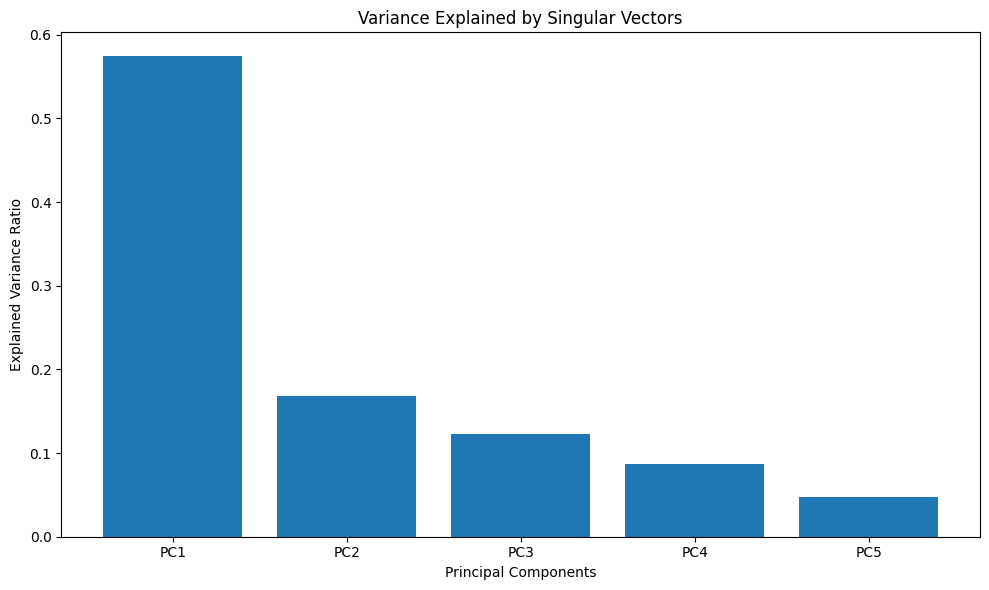

In [35]:
run_pollution_analysis('air_pollution_data.csv')